# **Homework 2 - Text Mining**

## Group Members:
1. **Iñigo Exposito**  
   <inigo.exposito@bse.eu>

2. **Deepak Malik**  
   <deepak.malik@bse.eu>

3. **Enzo Infantes**  
   <enzo.infantes@bse.eu>

<img src='https://upload.wikimedia.org/wikipedia/commons/4/41/BSE_primary_logo_color.jpg' width=300 />

# **0. Libraries**

In [97]:
import os
import time

import pandas as pd
import numpy as np
import re
import time
import swifter
from tabulate import tabulate
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from wordcloud import WordCloud

from packages.preprocessing import process_text_pipeline  
from packages.categories import categorize_articles
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from collections import Counter

# **1. Getting Main Text Data**

**Global News Dataset**: This dataset consists of news articles collected over the past few months using the NewsAPI (https://newsapi.org/). The main motivation for creating this dataset was to develop and experiment with various natural language processing (NLP) models. The goal of the dataset is to support the creation of text summarization models, sentiment analysis models, and other NLP applications.

**Source**: *Kumar Saksham. (2023). Global News Dataset [Data set]. Kaggle. https://doi.org/10.34740/KAGGLE/DSV/7105651*

In [58]:
df = pd.read_csv('data.csv')

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105375 entries, 0 to 105374
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   article_id    105375 non-null  int64 
 1   source_id     24495 non-null   object
 2   source_name   105375 non-null  object
 3   author        97156 non-null   object
 4   title         105335 non-null  object
 5   description   104992 non-null  object
 6   url           105375 non-null  object
 7   url_to_image  99751 non-null   object
 8   published_at  105375 non-null  object
 9   content       105375 non-null  object
 10  category      105333 non-null  object
 11  full_content  58432 non-null   object
dtypes: int64(1), object(11)
memory usage: 9.6+ MB


In [60]:
print(tabulate(df.head(3), headers='keys', tablefmt='psql'))
print(df.shape)

+----+--------------+-------------+------------------------------+--------------------------------------------+--------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------+----------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------+-------------------------------------------------------------------------------------------------------

**Drop Columns**: There are some columns that we won't need for the analysis, so we can drop them.
- `source_id`: Redundant because we already have 'source_name'.
- `url` and `url_to_image`: Not needed for our  analysis.
- `content`: We will use 'full_content' instead, which provides a more complete version.

In [61]:
df.drop(columns=['source_id', 'url', 'url_to_image', 'content'], inplace=True)

**Drop Duplicates:** To avoid having the same entry more than once, we decided to drop duplicates

In [62]:
df.drop_duplicates(inplace=True)
print(df.shape)

(101832, 8)


**Missing Values**: In this analysis, we need to have all the information from the `full_content` column because it contains the complete body of the news.

In [63]:
df.apply(lambda x: x.isnull().mean()).to_frame().sort_values(by=0, ascending=False).transpose()

,full_content,author,description,category,title,source_name,article_id,published_at
0,0.460985,0.080711,0.003732,0.000412,0.000393,0.0,0.0,0.0


**Missing Value Recategorization**: We perform recategorization to standardize missing values by replacing them with clear, consistent placeholder text. This ensures our analysis isn’t affected by null values.

In [64]:
df['author'].fillna('Unknown', inplace=True)
df['category'].fillna('Uncategorized', inplace=True)
df['title'].fillna('No Title', inplace=True)
df['description'].fillna('No Description', inplace=True)

print("\n=== Missing Values After Cleaning ===")
print(df.isna().sum())


=== Missing Values After Cleaning ===
article_id          0
source_name         0
author              0
title               0
description         0
published_at        0
category            0
full_content    46943
dtype: int64


**Target**: We now quantify missing 'full_content' entries to better understand the overall data quality and guide further cleaning steps. 
From the bar chart, we see that out of 101,832 total articles, **54,889** contain valid `full_content` (non-missing), whereas **46,943** articles have missing `full_content`. The pie chart further shows this distribution in percentage terms: roughly **53.9%** of the articles have full content, while **46.1%** are missing it.

Because our analysis will focus on the textual information within the `full_content` field, we plan to remove articles that do not contain this data. This ensures our subsequent text analysis is based solely on articles that actually have content.

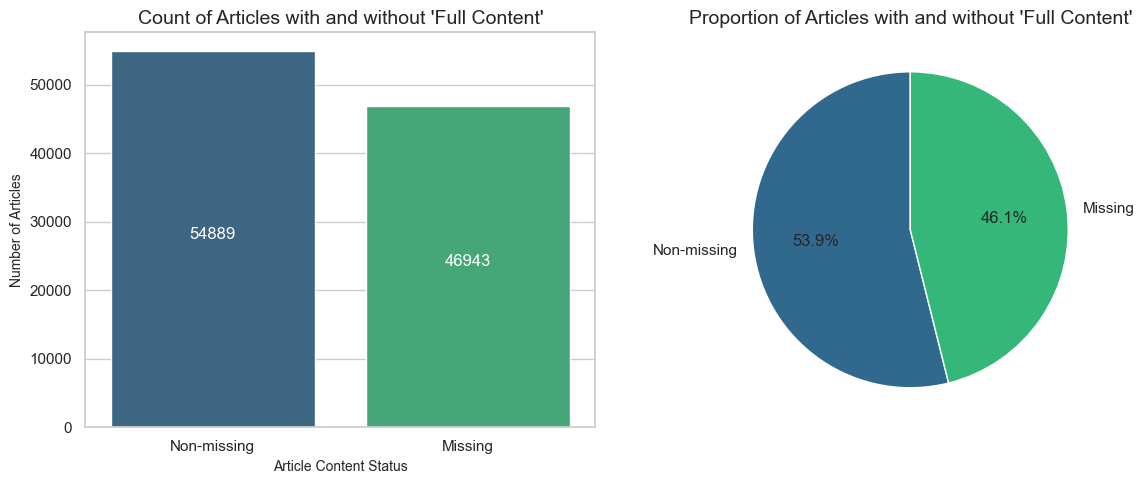

In [65]:
# Setting up a visual style
sns.set(style="whitegrid")

# Creating a summary
total_articles = len(df)
non_missing_count = df['full_content'].notna().sum()
missing_count = df['full_content'].isna().sum()

# Data for visualization
labels = ['Non-missing', 'Missing']
values = [non_missing_count, missing_count]

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Bar Chart
sns.barplot(x=labels, y=values, palette="viridis", ax=axes[0])
axes[0].set_title("Count of Articles with and without 'Full Content'", fontsize=14)
axes[0].set_xlabel("Article Content Status", fontsize=10)
axes[0].set_ylabel("Number of Articles", fontsize=10)

# Annotate bars
for i, count in enumerate(values):
    axes[0].text(i, count * 0.5, f"{count}", ha='center', fontsize=12, color='white')

# Pie Chart
colors = sns.color_palette("viridis", 2)
axes[1].pie(values, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
axes[1].set_title("Proportion of Articles with and without 'Full Content'", fontsize=14)

plt.tight_layout()
plt.show()

**Important Step**: Removing Articles with Missing `full_content`.

In [66]:
df.dropna(subset=['full_content'], inplace=True)

## **1.1. Preprocessing**

In this step, we are doing the following steps:
1. **Lowercasing** → Converts text to lowercase for consistency.
2. **Date Removal** → Uses regex to remove various date formats (e.g., "Jan 1, 2024", "12/15/2023").
3. **Special Character Removal** → Removes punctuation & non-alphanumeric characters.
4. **Tokenization & Lemmatization** → Uses **spaCy** to tokenize and lemmatize text.
5. **Stopword Removal** → Removes common and **news-related** stopwords.
6. **Parallel Processing** → Uses `swifter.apply()` for speed optimization.

**Note: `preprocess_dataframe`** is the function that contains all of these steps.

In [9]:
df = process_text_pipeline(df, text_column='full_content')

Pandas Apply: 100%|██████████| 20/20 [00:00<00:00, 13227.07it/s]


Documents containing 'th': 0 (0.00%)
Empty documents: 0 (0.00%)
Documents with 3 or fewer tokens: 0 (0.00%)


In [ ]:
print(tabulate(df.head(5), headers='keys', tablefmt='psql'))

+--------+--------------+--------------------+---------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------+---------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

**(a) Article Counts by Source Name**

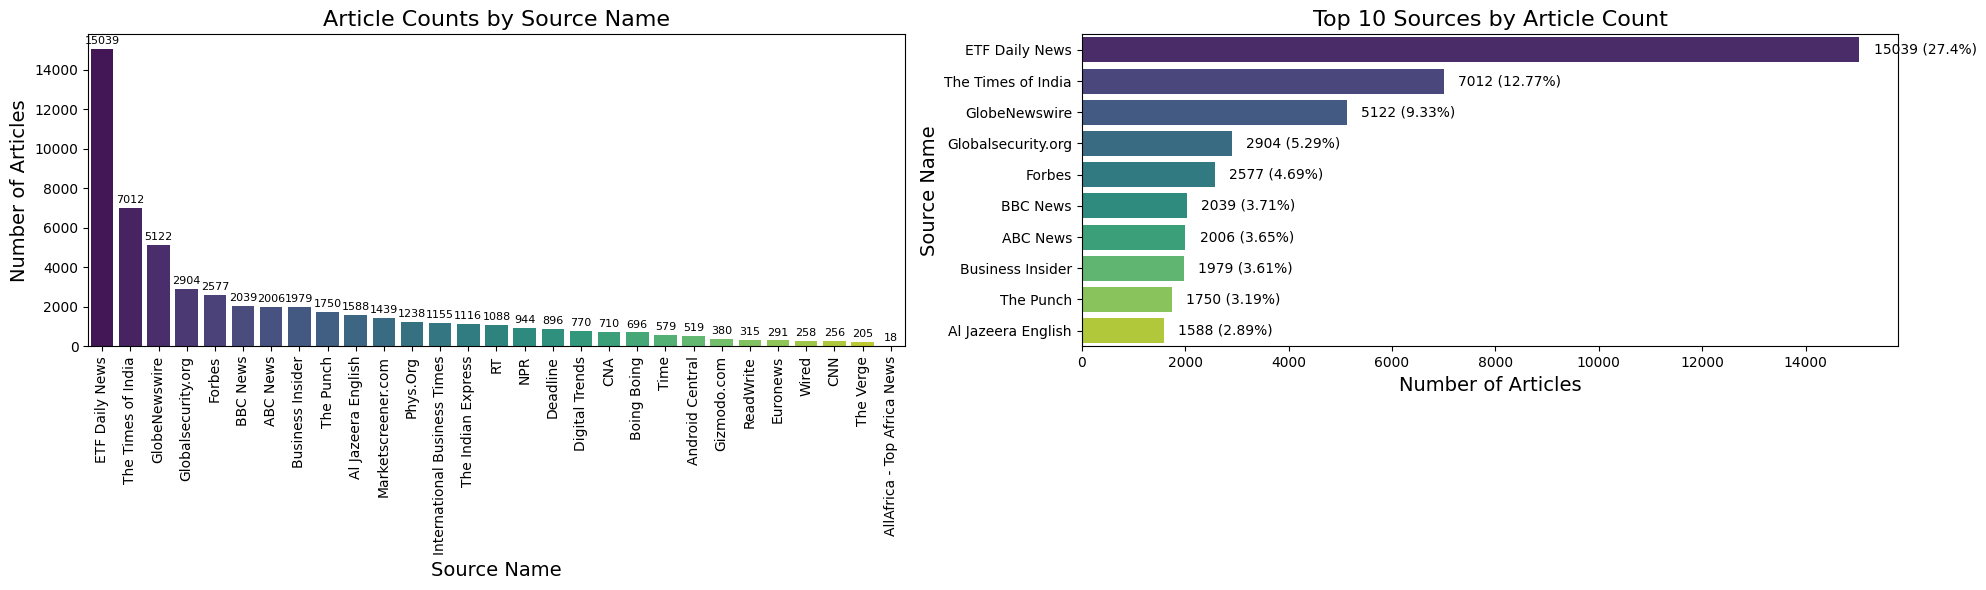


=== Top 10 Sources with Most Articles (Count & Percentage) ===
+--------------------+---------+--------------+
| Source Name        |   Count |   Percentage |
|--------------------+---------+--------------|
| ETF Daily News     |   15039 |        27.4  |
| The Times of India |    7012 |        12.77 |
| GlobeNewswire      |    5122 |         9.33 |
| Globalsecurity.org |    2904 |         5.29 |
| Forbes             |    2577 |         4.69 |
| BBC News           |    2039 |         3.71 |
| ABC News           |    2006 |         3.65 |
| Business Insider   |    1979 |         3.61 |
| The Punch          |    1750 |         3.19 |
| Al Jazeera English |    1588 |         2.89 |
+--------------------+---------+--------------+


In [21]:
source_counts = df['source_name'].value_counts()
total_articles = df.shape[0]
source_percentage = (source_counts / total_articles * 100).round(2)

# Prepare the top 10 sources DataFrame
top10_df = pd.DataFrame({
    'Source Name': source_counts.index,
    'Count': source_counts.values,
    'Percentage': source_percentage.values
}).head(10)

# Plotting article counts by source
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

# Barplot for article counts by source
sns.barplot(x=source_counts.index, y=source_counts.values, palette='viridis', ax=ax[0])
ax[0].set_title("Article Counts by Source Name", fontsize=16)
ax[0].set_xlabel("Source Name", fontsize=14)
ax[0].set_ylabel("Number of Articles", fontsize=14)
ax[0].tick_params(axis='x', rotation=90)  # Rotate x-axis labels to avoid overlap

# Annotate the bars with the count values
for i, count in enumerate(source_counts.values):
    ax[0].text(i, count + max(source_counts.values)*0.01, str(count), ha='center', va='bottom', fontsize=8)

# Horizontal barplot for top 10 sources
sns.barplot(x='Count', y='Source Name', data=top10_df, palette='viridis', ax=ax[1], orient='h')
ax[1].set_title("Top 10 Sources by Article Count", fontsize=16)
ax[1].set_xlabel("Number of Articles", fontsize=14)
ax[1].set_ylabel("Source Name", fontsize=14)

# Annotate each bar with the count and percentage
for idx, row in top10_df.iterrows():
    ax[1].text(row['Count'] + total_articles * 0.005, idx, 
               f"{row['Count']} ({row['Percentage']}%)", ha='left', va='center', fontsize=10)

plt.tight_layout()
plt.show()

print("\n=== Top 10 Sources with Most Articles (Count & Percentage) ===")
print(tabulate(top10_df, headers='keys', tablefmt='psql', showindex=False))

**(b) Article Counts Over Time**

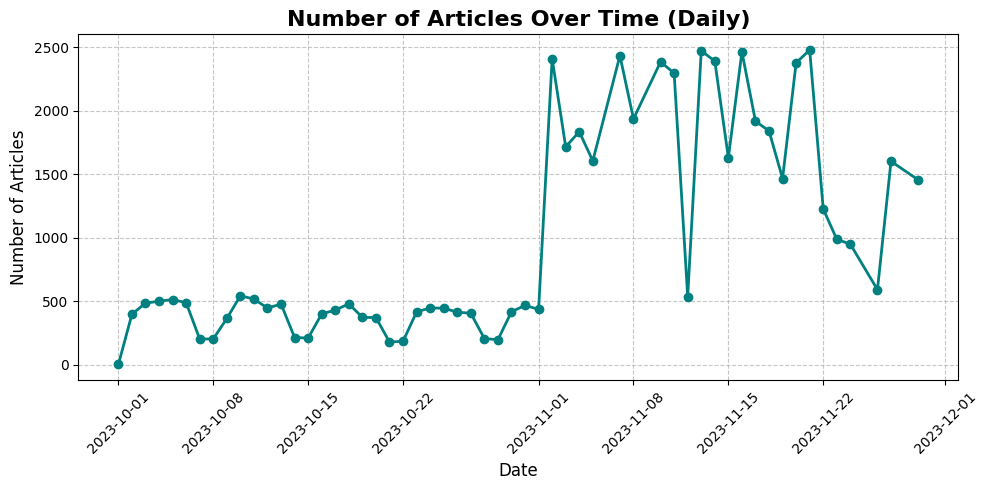

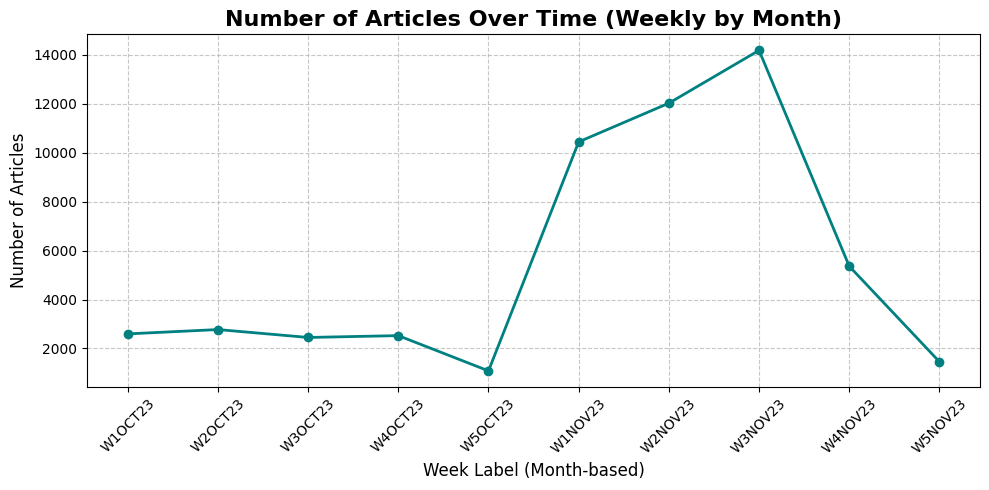

In [24]:
df['published_at'] = pd.to_datetime(df['published_at'], format='mixed', errors='raise')

df['date'] = df['published_at'].dt.date
date_summary = df['date'].value_counts().sort_index()

# Plot the daily article counts
plt.figure(figsize=(10, 5))
plt.plot(date_summary.index, date_summary.values, marker='o', linestyle='-', color='teal', linewidth=2)
plt.title("Number of Articles Over Time (Daily)", fontsize=16, fontweight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Number of Articles", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Drop previous week-related columns
df.drop(columns=[col for col in ['week_start', 'week_label', 'week_order'] if col in df.columns], inplace=True)

# Define the function for generating week labels in "W1OCT23" format
def monthly_week_label(dt):
    if pd.isna(dt):
        return "NA"
    return f"W{(dt.day - 1) // 7 + 1}{dt.strftime('%b%y').upper()}"

# Add 'week_label' and 'week_order' columns
df['week_label'] = df['published_at'].apply(monthly_week_label)
df['week_order'] = df['published_at'].apply(lambda x: x.year * 10000 + x.month * 100 + ((x.day - 1) // 7 + 1))

# Group by 'week_label' and get counts, sorting them chronologically
weekly_label_counts = df.groupby('week_label').size()
order_mapping = df.groupby('week_label')['week_order'].min()
weekly_label_counts = weekly_label_counts.loc[order_mapping.sort_values().index]

# Plot the weekly counts
plt.figure(figsize=(10, 5))
plt.plot(weekly_label_counts.index, weekly_label_counts.values, marker='o', linestyle='-', color='teal', linewidth=2)
plt.title("Number of Articles Over Time (Weekly by Month)", fontsize=16, fontweight='bold')
plt.xlabel("Week Label (Month-based)", fontsize=12)
plt.ylabel("Number of Articles", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**(c) Summary by Category**


=== Categories with More Articles Than the Mean ===
+-------------------------+---------+
| Count                   |   count |
|-------------------------+---------|
| Stock                   |    3275 |
| Canada                  |    1902 |
| Real estate             |    1896 |
| Health                  |    1833 |
| Technology              |    1731 |
| Finance                 |    1692 |
| News                    |    1297 |
| Education               |    1230 |
| COVID                   |    1217 |
| Food                    |    1011 |
| India                   |    1000 |
| Jobs                    |     893 |
| Asia                    |     885 |
| Weather                 |     880 |
| Travel                  |     850 |
| Australia               |     841 |
| Science                 |     809 |
| Africa                  |     733 |
| United Kingdom          |     724 |
| Cars                    |     721 |
| Climate                 |     668 |
| Artificial Intelligence |     648

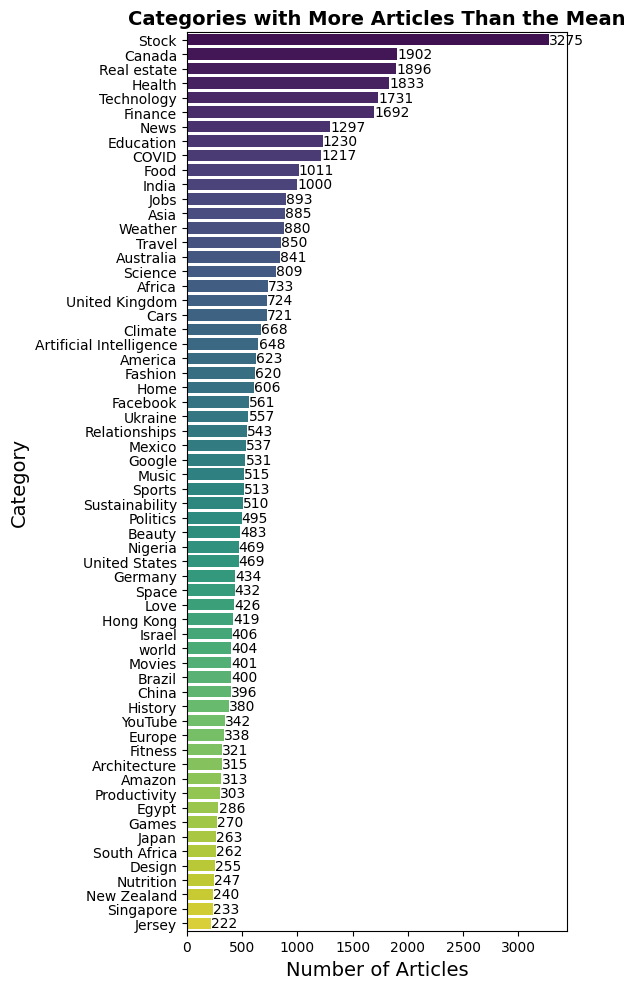

In [28]:
category_counts = df['category'].value_counts()
mean_count = category_counts.mean()

# Filter and sort categories with article counts above the mean
categories_above_mean = category_counts[category_counts > mean_count].sort_values(ascending=False)

# Create a table of categories with more articles than the mean
table_df = categories_above_mean.reset_index().rename(columns={'index': 'Category', 'category': 'Count'})

# Print the formatted table
print("\n=== Categories with More Articles Than the Mean ===")
print(tabulate(table_df, headers='keys', tablefmt='psql', showindex=False))

# Plot a horizontal bar chart for better readability
plt.figure(figsize=(6, 10))
ax = sns.barplot(x=categories_above_mean.values, y=categories_above_mean.index, palette='viridis')

# Adding title and labels
plt.title("Categories with More Articles Than the Mean", fontsize=14, fontweight='bold')
plt.xlabel("Number of Articles", fontsize=14)
plt.ylabel("Category", fontsize=14)

# Annotate each bar with the count value
for i, count in enumerate(categories_above_mean.values):
    ax.text(count + 1, i, str(count), color='black', va='center', fontsize=10)

plt.tight_layout()
plt.show()

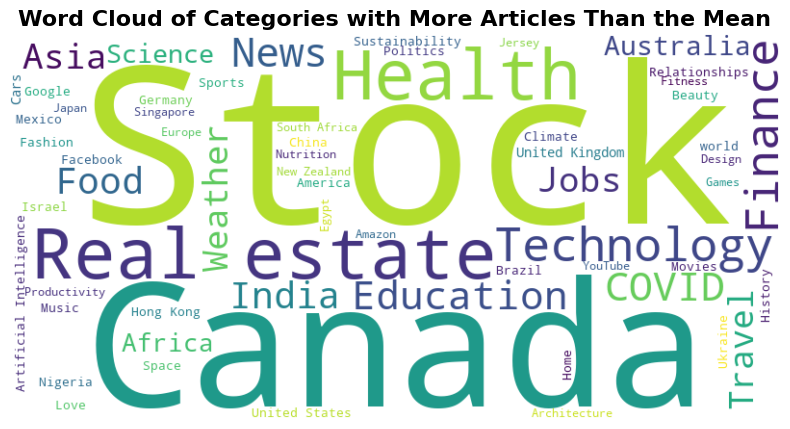

In [29]:
# Convert categories_above_mean into a dictionary: {category: count}
cat_dict = dict(zip(categories_above_mean.index, categories_above_mean.values))

# Create a word cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis'
).generate_from_frequencies(cat_dict)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Categories with More Articles Than the Mean", fontsize=16, fontweight='bold')
plt.show()

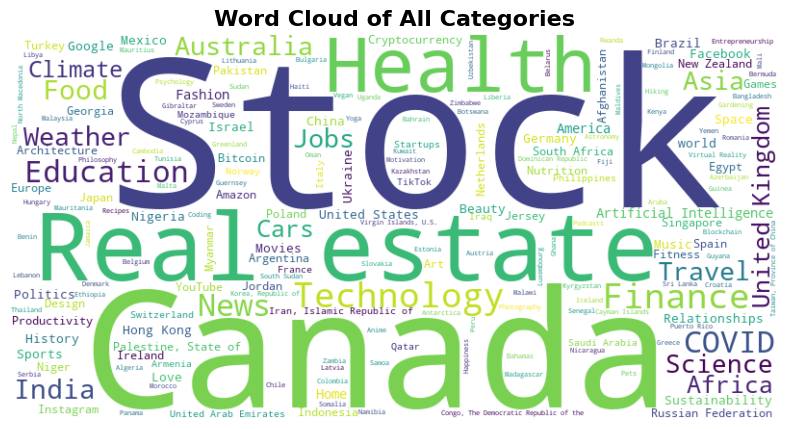

In [30]:
# Convert the full category counts into a dictionary: {category: count}
all_cat_dict = df['category'].value_counts().to_dict()

# Create a word cloud from the full category frequencies
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis'
).generate_from_frequencies(all_cat_dict)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of All Categories", fontsize=16, fontweight='bold')
plt.show()

**Note**: Creating New Category Column by banding similar things together. For this step, we are using `categories.py` file when we defined the logic to create these categories. 

1. **Category Mapping**: Defines broad categories (e.g., Geography, Technology, Lifestyle) and maps specific keywords (countries, tech terms, etc.) to these categories.
2. **Categorizing Articles**: Assigns each article to a broad category based on its current category. If no match is found, it's labeled as "Uncategorized."
3. **Cleaning**: Adds a new `Broad_category` column and removes rows labeled as "Uncategorized."
4. **Result**: The DataFrame is updated with broader categories, and uncategorized rows are dropped.

In [31]:
df = categorize_articles(df)

Uncategorized categories: ['Uncategorized' 'Congo, The Democratic Republic of the']



=== Frequency of Broad Categories ===
+-------------------------------+-------------+
| Broad_category                |   Frequency |
|-------------------------------+-------------|
| Geography & Places            |       23649 |
| Technology & Digital Economy  |       15172 |
| Knowledge & Current Affairs   |        6936 |
| Lifestyle & Wellness          |        5954 |
| Arts, Culture & Entertainment |        3048 |
+-------------------------------+-------------+


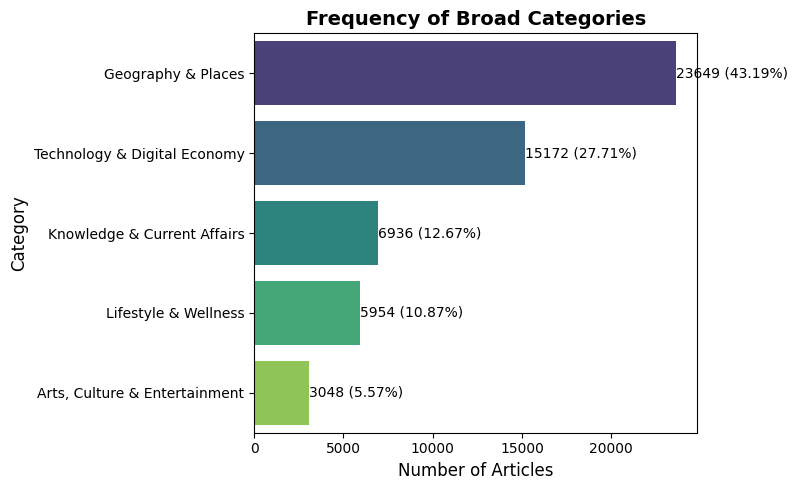

In [33]:
# Compute and display the frequency table
frequency_df = df['Broad_category'].value_counts().reset_index()
frequency_df.columns = ['Broad_category', 'Frequency']
print("\n=== Frequency of Broad Categories ===")
print(tabulate(frequency_df, headers='keys', tablefmt='psql', showindex=False))

# Plot horizontal bar chart with annotated values
plt.figure(figsize=(8, 5))
ax = sns.barplot(x=frequency_df['Frequency'], y=frequency_df['Broad_category'], palette='viridis')
plt.title("Frequency of Broad Categories", fontsize=14, fontweight='bold')
plt.xlabel("Number of Articles", fontsize=12)
plt.ylabel("Category", fontsize=12)

# Annotate each bar with count and percentage
total_count = df.shape[0]
for i, count in enumerate(frequency_df['Frequency']):
    ax.text(count + 1, i, f"{count} ({(count / total_count) * 100:.2f}%)", color='black', va='center', fontsize=10)

plt.tight_layout()
plt.show()


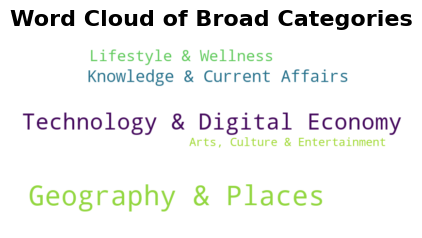

In [34]:
# Convert the broad_category counts into a dictionary: {broad_category: count}
broad_cat_dict = df['Broad_category'].value_counts().to_dict()

# Create a word cloud from the broad_category frequencies
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis'
).generate_from_frequencies(broad_cat_dict)

# Plot the word cloud
plt.figure(figsize=(5, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Broad Categories", fontsize=16, fontweight='bold')
plt.show()

## **1.2. Bivariate Analysis**
We will try to identify some patterns around our categories, dates, and number of articles.

In [35]:
# Group by week_label and Broad_category to calculate weekly counts per category
weekly_category_summary = df.pivot_table(index='week_label', columns='Broad_category', aggfunc='size', fill_value=0)

# Reorder rows based on the minimum week_order for each week_label
weekly_category_summary = weekly_category_summary.loc[df.groupby('week_label')['week_order'].min().sort_values().index]

# Calculate percentage distribution
percentage_distribution = weekly_category_summary.div(weekly_category_summary.sum(axis=1), axis=0) * 100

# Print the weekly summary in a formatted table
print("\n=== Weekly Distribution of Articles by Category ===")
print(tabulate(weekly_category_summary, headers='keys', tablefmt='psql'))


=== Weekly Distribution of Articles by Category ===
+--------------+---------------------------------+----------------------+-------------------------------+------------------------+--------------------------------+
| week_label   |   Arts, Culture & Entertainment |   Geography & Places |   Knowledge & Current Affairs |   Lifestyle & Wellness |   Technology & Digital Economy |
|--------------+---------------------------------+----------------------+-------------------------------+------------------------+--------------------------------|
| W1OCT23      |                              94 |                 1880 |                           207 |                    119 |                            271 |
| W2OCT23      |                             111 |                 2012 |                           171 |                    126 |                            328 |
| W3OCT23      |                              89 |                 1774 |                           160 |                    12

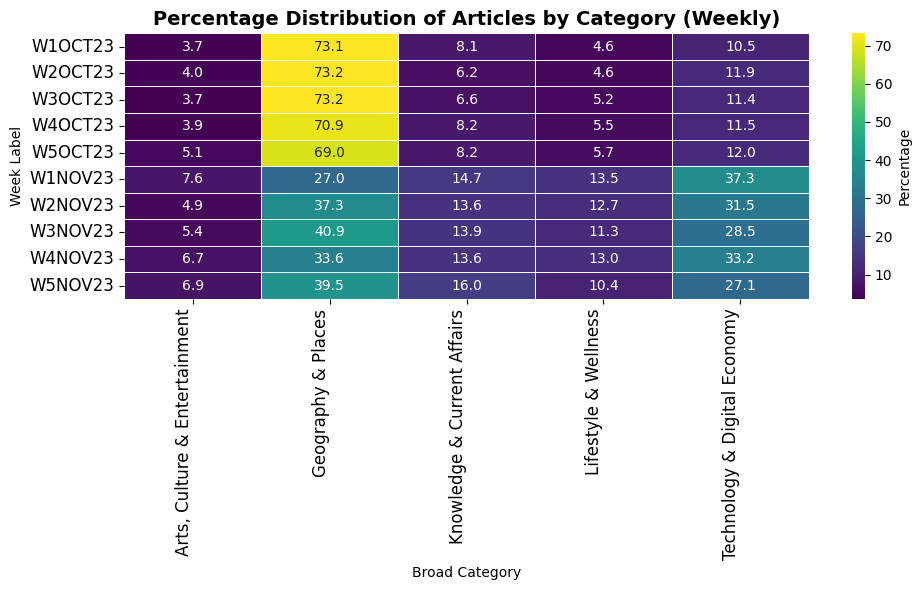

In [38]:
# ---------------------------
# Heatmap for Percentage Distribution
# ---------------------------
plt.figure(figsize=(10, 6))
sns.heatmap(
    percentage_distribution, 
    annot=True, 
    fmt=".1f", 
    cmap='viridis', 
    cbar_kws={'label': 'Percentage'},
    linewidths=0.5,
    linecolor='white'
)
plt.title("Percentage Distribution of Articles by Category (Weekly)", fontsize=14, fontweight='bold')
plt.xlabel("Broad Category", fontsize=10)
plt.ylabel("Week Label", fontsize=10)
plt.xticks(rotation=90, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

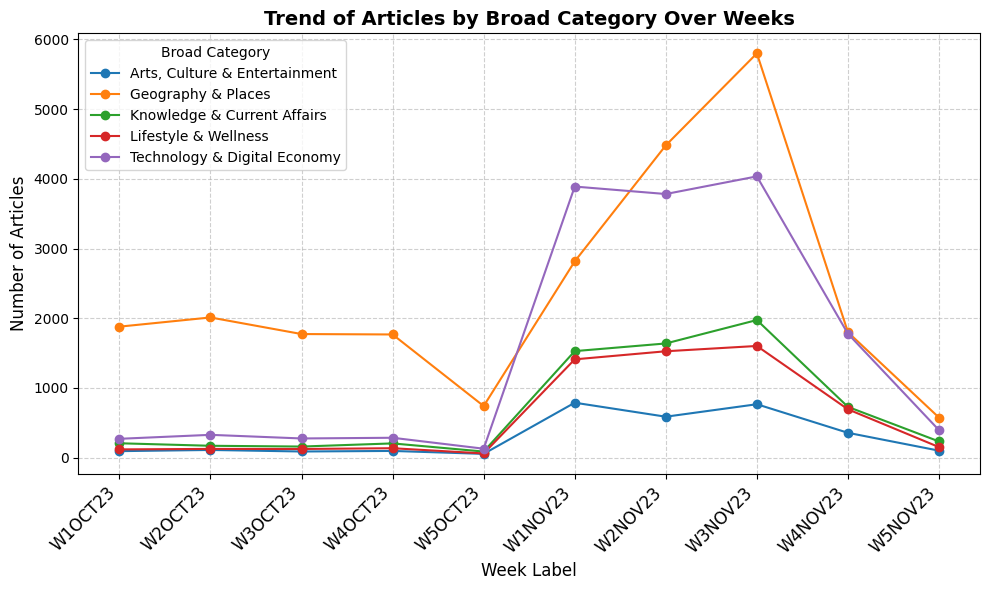

In [40]:
# ---------------------------
# Trend Line Graphs for Each Broad Category
# ---------------------------
plt.figure(figsize=(10, 6))
for category, values in weekly_category_summary.items():
    plt.plot(weekly_category_summary.index, values, marker='o', linestyle='-', label=category)

plt.title("Trend of Articles by Broad Category Over Weeks", fontsize=14, fontweight='bold')
plt.xlabel("Week Label", fontsize=12)
plt.ylabel("Number of Articles", fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.legend(title="Broad Category", fontsize=10, loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Unique article count for Technology & Digital Economy: 14853


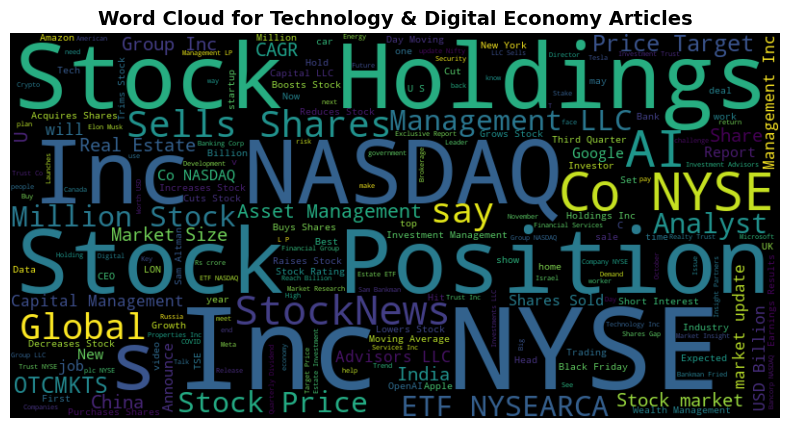

Unique article count for Geography & Places: 23094


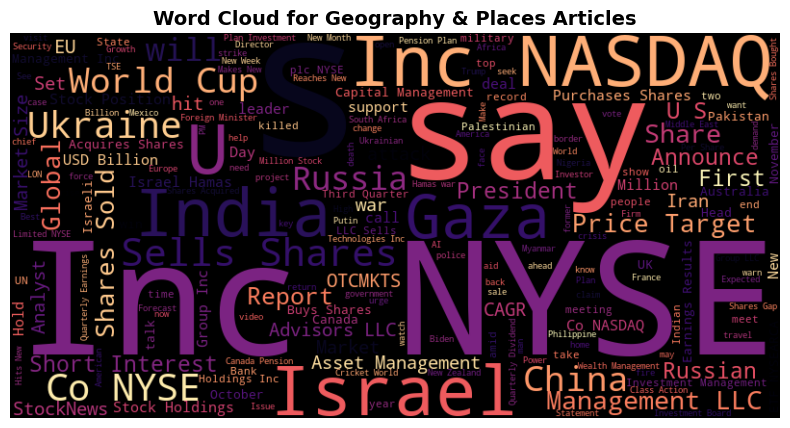

In [41]:
# ---------------------------
# Filter Dataset for Technology and Geography Articles
# ---------------------------
categories = {
    "Technology & Digital Economy": "viridis",
    "Geography & Places": "magma"
}

for category, colormap in categories.items():
    articles = df[df['Broad_category'] == category]
    unique_count = articles['title'].nunique()
    
    print(f"Unique article count for {category}: {unique_count}")

    # Generate Word Cloud
    text = ' '.join(articles['title'].dropna())
    wordcloud = WordCloud(width=800, height=400, background_color='black', colormap=colormap).generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud for {category} Articles", fontsize=14, fontweight='bold')
    plt.show()



=== Unique Categories in Technology & Digital Economy per Week ===
+--------------+----------+---------------------------+-----------+--------------+---------+--------+----------+------------------+--------------------+------------+-----------+----------+-------------+--------+----------------+---------------+------------+---------+--------------+----------+-------------------+-----------+
| week_label   |   Amazon |   Artificial Intelligence |   Bitcoin |   Blockchain |   COVID |   Cars |   Coding |   Cryptocurrency |   Entrepreneurship |   Facebook |   Finance |   Google |   Instagram |   Jobs |   Productivity |   Real estate |   Startups |   Stock |   Technology |   TikTok |   Virtual Reality |   YouTube |
|--------------+----------+---------------------------+-----------+--------------+---------+--------+----------+------------------+--------------------+------------+-----------+----------+-------------+--------+----------------+---------------+------------+---------+-------------

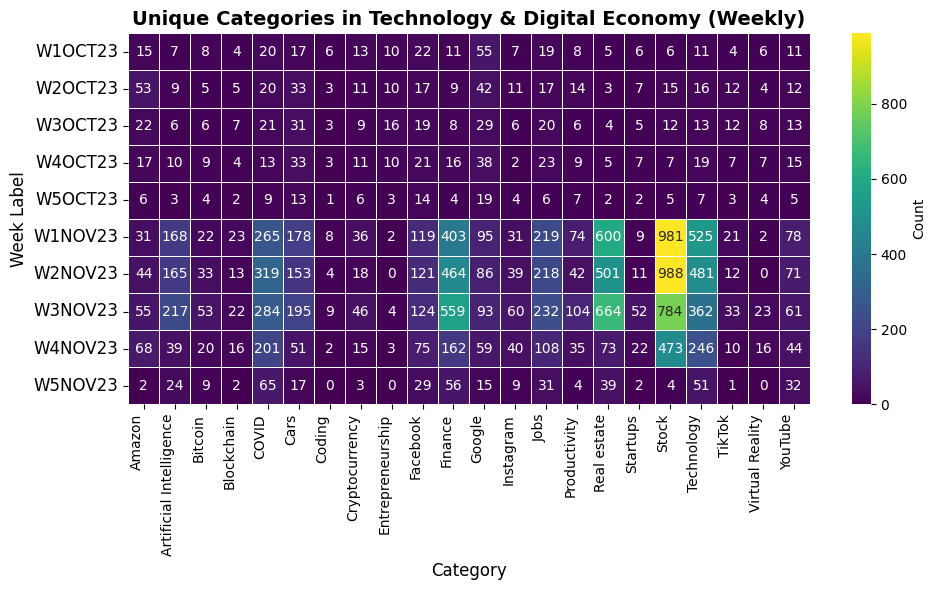

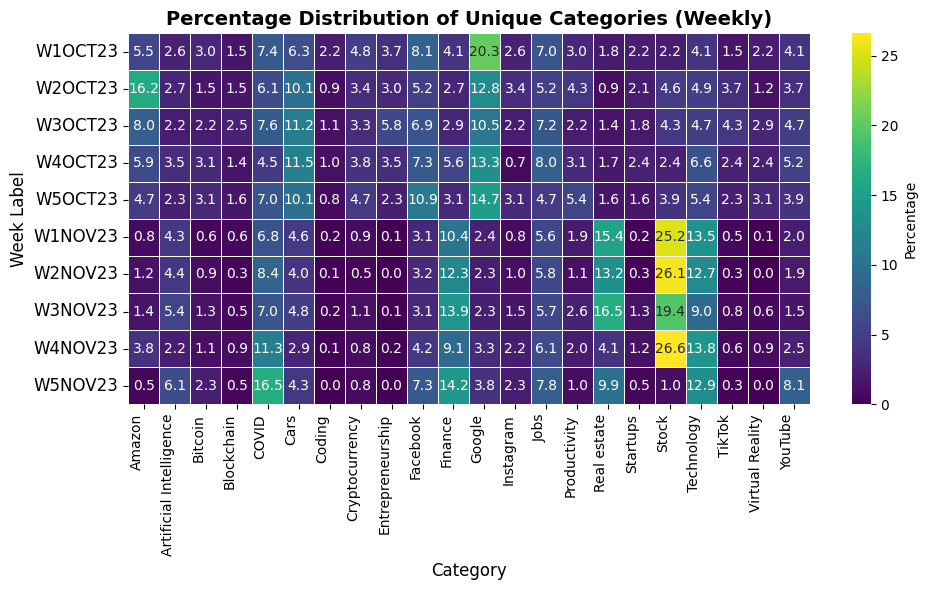

In [43]:
# ---------------------------
# Filter & Cross-Tabulate Data for Technology & Digital Economy
# ---------------------------
tech_df = df[df['Broad_category'] == 'Technology & Digital Economy']

# Create cross-tabulation (count and percentage)
cross_tab_count = pd.crosstab(tech_df['week_label'], tech_df['category'])
cross_tab_pct = cross_tab_count.div(cross_tab_count.sum(axis=1), axis=0) * 100

# Sort week labels using week_order if available
if 'week_order' in df.columns:
    sorted_weeks = df[['week_label', 'week_order']].drop_duplicates().set_index('week_label')['week_order'].sort_values().index
    cross_tab_count = cross_tab_count.reindex(sorted_weeks)
    cross_tab_pct = cross_tab_pct.reindex(sorted_weeks)
else:
    print("Warning: 'week_order' column missing. Sorting may be inaccurate.")

# Display tables
print("\n=== Unique Categories in Technology & Digital Economy per Week ===")
print(tabulate(cross_tab_count, headers='keys', tablefmt='psql'))

print("\n=== Percentage Distribution of Unique Categories per Week ===")
print(tabulate(cross_tab_pct, headers='keys', tablefmt='psql', floatfmt=".2f"))

# --- Function for Heatmap Plotting ---
def plot_heatmap(data, title, fmt, cbar_label):
    plt.figure(figsize=(10, 6))
    sns.heatmap(data, annot=True, fmt=fmt, cmap='viridis', linewidths=0.5, linecolor='white', cbar_kws={'label': cbar_label})
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel("Category", fontsize=12)
    plt.ylabel("Week Label", fontsize=12)
    plt.xticks(rotation=90, ha='right', fontsize=10)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

# --- Generate Heatmaps ---
plot_heatmap(cross_tab_count, "Unique Categories in Technology & Digital Economy (Weekly)", "d", "Count")
plot_heatmap(cross_tab_pct, "Percentage Distribution of Unique Categories (Weekly)", ".1f", "Percentage")



=== Article Counts by Source and Broad Category ===
+------------------------------+---------------------------------+----------------------+-------------------------------+------------------------+--------------------------------+
| source_name                  |   Arts, Culture & Entertainment |   Geography & Places |   Knowledge & Current Affairs |   Lifestyle & Wellness |   Technology & Digital Economy |
|------------------------------+---------------------------------+----------------------+-------------------------------+------------------------+--------------------------------|
| ABC News                     |                              91 |                 1036 |                           353 |                    204 |                            318 |
| Al Jazeera English           |                              31 |                  942 |                           273 |                    241 |                             99 |
| AllAfrica - Top Africa News  |               

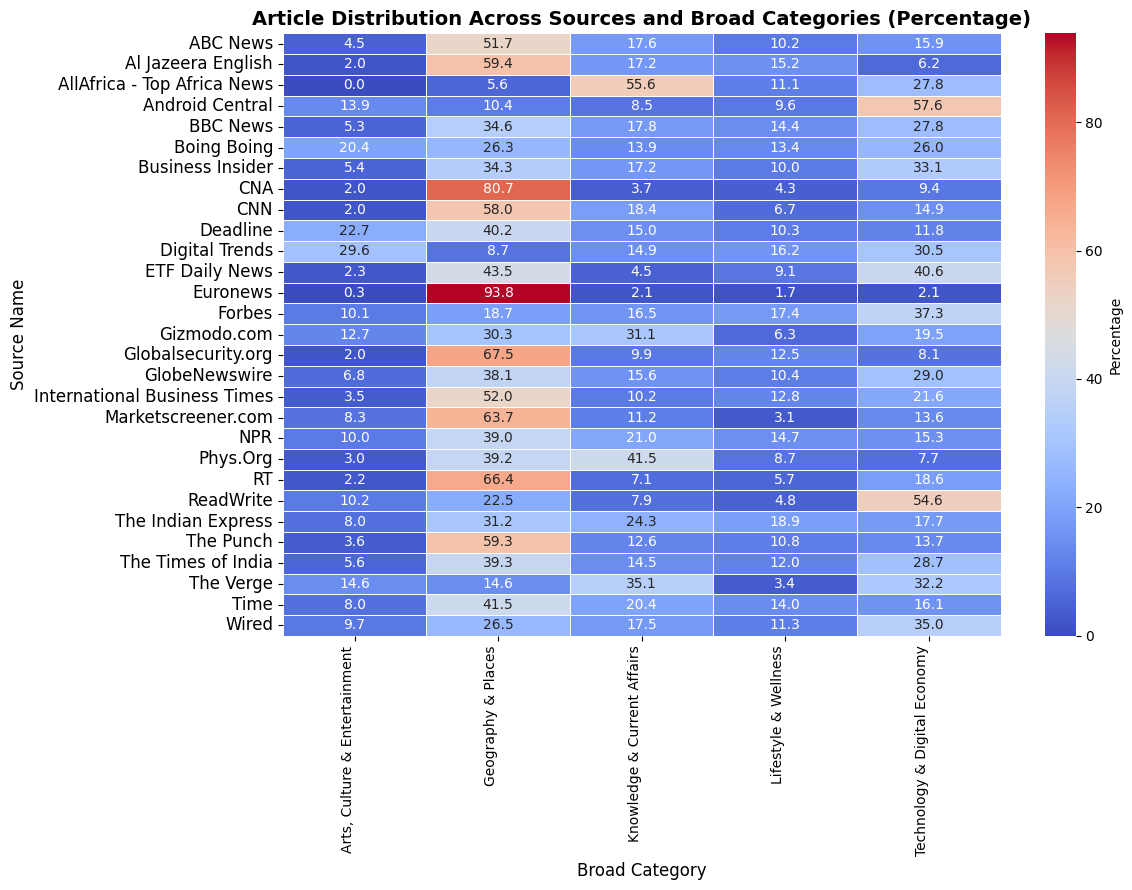

In [47]:
# ---------------------------
#  Group and Pivot Data 
# ---------------------------
source_category_summary = df.pivot_table(index='source_name', columns='Broad_category', aggfunc='size', fill_value=0)

print("\n=== Article Counts by Source and Broad Category ===")
print(tabulate(source_category_summary, headers='keys', tablefmt='psql'))

# --- Compute Percentage Distribution ---
source_category_percentage = source_category_summary.div(source_category_summary.sum(axis=1), axis=0) * 100

# --- Heatmap Function ---
def plot_heatmap(data, title):
    plt.figure(figsize=(12, 9))
    sns.heatmap(data, annot=True, fmt=".1f", cmap='coolwarm', linewidths=0.5, linecolor='white', cbar_kws={'label': 'Percentage'})
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel("Broad Category", fontsize=12)
    plt.ylabel("Source Name", fontsize=12)
    plt.xticks(rotation=90, ha='right', fontsize=10)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

# --- Plot Heatmap ---
plot_heatmap(source_category_percentage, "Article Distribution Across Sources and Broad Categories (Percentage)")

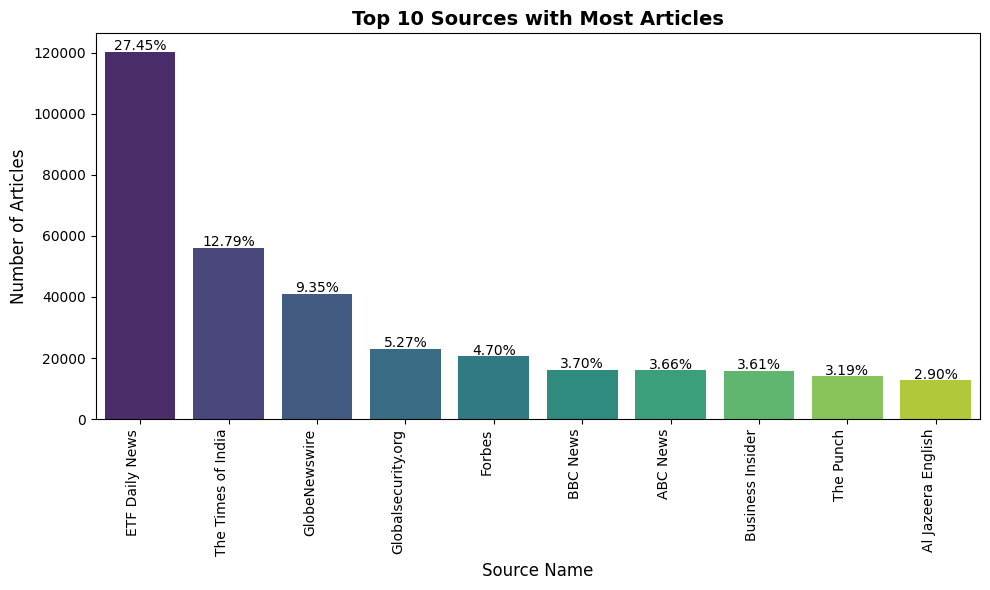

In [55]:
# ---------------------------
# Calculate Total Articles Per Source 
# ---------------------------
source_category_summary['Total'] = source_category_summary.sum(axis=1)

# --- Get Top 10 Sources by Total Articles ---
top_10_sources = source_category_summary['Total'].nlargest(10)

# --- Plot Top Sources ---
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=top_10_sources.index, y=top_10_sources.values, palette="viridis")

plt.title("Top 10 Sources with Most Articles", fontsize=14, fontweight='bold')
plt.xlabel("Source Name", fontsize=12)
plt.ylabel("Number of Articles", fontsize=12)
plt.xticks(rotation=90, ha='right', fontsize=10)

# --- Annotate Bars with Percentages ---
total_articles = source_category_summary['Total'].sum()
percentages = top_10_sources / total_articles * 100

for i, (count, percentage) in enumerate(zip(top_10_sources.values, percentages)):
    ax.text(i, count + 500, f"{percentage:.2f}%", ha='center', fontsize=10)

plt.tight_layout()
plt.show()

### **Final Preprocessed Data Overview**

The final preprocessed dataset (`final_preprocessed_data`) contains the following columns:

1. **article_id**  
   *Description:* Unique identifier for each article.  
   *Usage:* Useful for tracking and linking articles across analyses.

2. **source_name**  
   *Description:* The name of the news source that published the article.  
   *Usage:* Allows grouping and analysis by news outlet to study media bias or source-specific trends.

3. **published_at**  
   *Description:* The publication date and time of the article (converted to a datetime format).  
   *Usage:* Facilitates time-based analysis, such as trends over days, weeks, or months.

4. **full_content**  
   *Description:* The original text content of the article, if available.  
   *Usage:* Serves as the raw text from which the processed content is derived.

5. **processed_content**  
   *Description:* The cleaned and preprocessed version of the article text. This includes steps like lowercasing, punctuation removal, tokenization, stopword removal, and stemming/lemmatization.  
   *Usage:* Used for subsequent text analysis tasks such as dictionary generation, topic modeling, and sentiment analysis.

6. **processed_preview**  
   *Description:* A short preview (first 200 characters) of the `processed_content`, with an ellipsis appended if the text is longer.  
   *Usage:* Provides a quick visual check of the preprocessed text without displaying the full content.

7. **category**  
   *Description:* The topic or category assigned to the article (e.g., Politics, Technology, Health).  
   *Usage:* Enables grouping and comparative analysis of articles by topic.

8. **week_start**  
   *Description:* The starting date (typically Monday) of the week in which the article was published.  
   *Usage:* Useful for aggregating articles on a weekly basis for time-series analysis.

9. **week_label**  
   *Description:* A custom label representing the week within a month (e.g., "W1OCT23"), created using the publication date.  
   *Usage:* Provides an intuitive and human-friendly way to view and compare weekly article trends.

10. **week_order**  
    *Description:* A numeric value combining the year, month, and week number (calculated as `year*10000 + month*100 + week_in_month`) used solely for sorting weekly summaries in chronological order.  
    *Usage:* Ensures that weekly data is correctly ordered when visualizing trends over time.

These columns collectively provide a robust foundation for further analysis, allowing you to explore temporal trends, media bias, vocabulary usage across categories, and more.


In [ ]:
df.to_csv("final_preprocessed_data.csv", index=False)

# --- Display Sample Data ---
print("\n=== Final Preprocessed Data (Sample) ===")
print(tabulate(df.head(), headers='keys', tablefmt='psql'))


=== Final Preprocessed Data (Sample) ===
+----+--------------+------------------------------+--------------------+------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------+------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# **2. Develop Methodology and Implementation**

**Research Question:**  
"How did media narratives evolve from a predominantly geopolitical focus in October 2023 to a more technology-driven discourse in November 2023, and what specific linguistic markers distinguish these shifts in coverage?"

**Group Findings Description:**  
Our analysis of the Global News Dataset for October–November 2023 revealed a striking temporal transition in the topics covered by media outlets. In October, our dictionary-based analysis showed that "Geography & Places" dominated the news content—with approximately 70–73% of articles concentrating on geopolitical issues. However, by November, there was a notable rebalancing in the distribution, with "Technology & Digital Economy" emerging strongly, accounting for 30–37% of the content compared to a drop in geographic focus.

This shift aligns with real-world events during the period:
- The escalation of the **Israel-Hamas conflict** in early October likely contributed to the heavy emphasis on geographic and geopolitical reporting.
- In contrast, early November witnessed significant technological milestones, such as the release of **GPT-4 Turbo** by OpenAI and Meta’s launch of **Threads** as a competitor to Twitter.

Our research question thus seeks to uncover not only the extent of this narrative shift but also to identify the linguistic markers—via dictionary-based methods—that characterize the transition from geopolitical to technology-centric reporting. This investigation promises to yield insights into how external events influence media framing and the evolution of public discourse.

In [ ]:
final_preprocessed_data = pd.read_csv('final_preprocessed_data.csv')

In [ ]:
df = final_preprocessed_data.copy()

**Methodology 01**: Garcia-Uribe et al (2023)
- According to our research question, we will focus on the content of the articles to find the most frequent words in the categories of Geography & Places and Technology & Digital Economy.
- We will adjust the vectorizer for geopolitical and technology content, considering that in this analysis we only have two types of text.
- We will show the top 20 words in each category.

In [ ]:
geo_data = df[df['Broad_category'] == 'Geography & Places']['processed_content']
tech_data = df[df['Broad_category'] == 'Technology & Digital Economy']['processed_content']

vectorizer = TfidfVectorizer(stop_words='english', max_df=0.35, min_df=0.1, max_features=1000)

geo_tfidf = vectorizer.fit_transform(geo_data)
geo_features = vectorizer.get_feature_names_out()

tech_tfidf = vectorizer.fit_transform(tech_data)
tech_features = vectorizer.get_feature_names_out()

geo_df = pd.DataFrame(geo_tfidf.toarray(), columns=geo_features)
tech_df = pd.DataFrame(tech_tfidf.toarray(), columns=tech_features)

geo_top_terms = geo_df.sum().sort_values(ascending=False).head(20)
tech_top_terms = tech_df.sum().sort_values(ascending=False).head(20)

print("Top terms in Geography & Places:")
print(geo_top_terms)

print("\nTop terms in Technology & Digital Economy:")
print(tech_top_terms)

Top terms in Geography & Places:
buy           1228.318077
ratio         1174.324508
average       1100.587522
israel        1075.785003
india         1042.083342
people         999.266150
country        976.969464
value          948.548757
dividend       927.061867
world          900.324593
service        831.764807
sell           829.994317
additional     809.311908
target         799.435654
llc            783.712235
worth          741.761458
government     733.344270
security       722.820823
say            717.888802
president      716.401446
dtype: float64

Top terms in Technology & Digital Economy:
dividend       910.765813
llc            894.909784
transaction    693.179761
bank           670.157776
earnings       626.289578
stake          622.343976
october        607.638287
purchase       605.218835
holding        595.099380
india          569.784371
use            565.967145
trade          548.215117
acquire        522.106754
real           515.506583
product        514.66714

Our project aims to track the evolution of media narratives from a geopolitical focus in October 2023 to a technology-driven discourse in November 2023. The TF-IDF analysis of the Global News Dataset for these months reveals a noticeable shift in focus:

**Geography & Places**:
- Top terms: buy, ratio, average, Israel, India, people, country, value, dividend.
- Interpretation: The presence of terms like Israel, India, country, and people indicates a strong emphasis on geopolitical events and locations. Terms like buy, ratio, average, and value suggest that these articles also incorporate economic analysis relevant to geopolitical contexts. Additional terms such as government, security, and president further emphasize the political and governance aspects of the reporting.

**Technology & Digital Economy**:
- Top terms: dividend, LLC, transaction, bank, earnings, stake.
- Interpretation: The prominence of terms such as LLC, transaction, bank, earnings, and stake highlights a shift towards discussions on financial investments, business structures, and economic transactions. Words like purchase, holding, and trade point to a focus on market activities and capital flows within the technology sector.
  
---

**Methodology 02**: Hassan et al (2019)
- According to our research question, we will focus on the content of the articles to find the most frequent words in the categories of Geography & Places and Technology & Digital Economy.
- We will adjust the vectorizer for geopolitical and technology content. In this case we are using Bi-grams according with the methodology.
- We will show the top 20 words in each category.

In [ ]:
# Split data into Geography & Places and Technology & Digital Economy libraries
geo_data = df[df['Broad_category'] == 'Geography & Places']
tech_data = df[df['Broad_category'] == 'Technology & Digital Economy']

# Initialize the CountVectorizer to extract bigrams
vectorizer = CountVectorizer(ngram_range=(2,2), min_df=0.05, max_df=0.4, stop_words='english')

# Fit the vectorizer on the combined data
combined_data = pd.concat([geo_df['processed_content'], tech_df['processed_content']])
vectorizer.fit(combined_data)

# Transform the 'processed_content' for both categories
geo_bigrams = vectorizer.transform(geo_df['processed_content'])
tech_bigrams = vectorizer.transform(tech_df['processed_content'])

# Get bigram features (terms)
bigram_features = vectorizer.get_feature_names_out()

# Convert to DataFrame for easier manipulation
geo_bigrams_df = pd.DataFrame(geo_bigrams.toarray(), columns=bigram_features)
tech_bigrams_df = pd.DataFrame(tech_bigrams.toarray(), columns=bigram_features)

# Calculate frequencies
geo_frequencies = geo_bigrams_df.sum(axis=0)  # Frequency of bigrams in Geography & Places
tech_frequencies = tech_bigrams_df.sum(axis=0)  # Frequency of bigrams in Technology & Digital Economy

# Calculate total number of bigrams in each library
geo_total_bigrams = geo_bigrams_df.sum().sum()
tech_total_bigrams = tech_bigrams_df.sum().sum()

# Calculate fb,P/BP for each bigram
geo_bigrams_ratio = geo_frequencies / geo_total_bigrams * 1e5  # Scaling to match example
tech_bigrams_ratio = tech_frequencies / tech_total_bigrams * 1e5  # Scaling to match example

# Combine both ratios into a DataFrame for comparison
bigrams_ratio_df = pd.DataFrame({'Geo': geo_bigrams_ratio, 'Tech': tech_bigrams_ratio}).fillna(0)

# Display top bigrams for Geography & Places
geo_top_bigrams = bigrams_ratio_df['Geo'].sort_values(ascending=False).head(20)
print("Top bigrams for Geography & Places (Political) Library:")
print(geo_top_bigrams)

# Display top bigrams for Technology & Digital Economy
tech_top_bigrams = bigrams_ratio_df['Tech'].sort_values(ascending=False).head(20)
print("Top bigrams for Technology & Digital Economy Library:")
print(tech_top_bigrams)

Top bigrams for Geography & Places (Political) Library:
institutional investor    1525.779323
hedge fund                1360.070677
day average               1345.211812
united state              1325.346155
purchase additional       1163.675243
buy hold                  1126.205062
additional period         1027.199798
best buy                  1024.615648
want great                1017.186215
idea sell                 1015.086593
sell double               1015.086593
yearthe best              1014.925084
double yearthe            1014.925084
invest idea               1014.925084
great invest              1014.925084
earnings share             986.822448
average day                952.743964
acquire additional         889.432278
security exchange          850.347003
ratio beta                 845.178702
Name: Geo, dtype: float64
Top bigrams for Technology & Digital Economy Library:
real estate               1668.383906
institutional investor    1594.135995
hedge fund                14

Our project aims to track the evolution of media narratives from a geopolitical focus in October 2023 to a technology-driven discourse in November 2023. The CountVectorizer analysis using the Hassan et al. (2019) methodology of the Global News Dataset for these months reveals a noticeable shift in focus:

**Geography & Places**:
- Top bigrams: institutional investor, hedge fund, day average, united state, purchase additional.
- Interpretation: The prominence of bigrams like "institutional investor," "hedge fund," and "day average" reflects a strong emphasis on economic and financial contexts within geopolitical reporting. The presence of "united state" emphasizes geopolitical locations, and terms like "purchase additional" suggest discussions around transactions and investments.

**Technology & Digital Economy**:
- Top bigrams: real estate, institutional investor, hedge fund, day average, purchase additional.
- Interpretation: The presence of bigrams like "real estate," "institutional investor," and "hedge fund" indicates a focus on financial and investment aspects within the technology sector. The bigram "day average" points to discussions on market analysis, and "purchase additional" suggests a focus on transactions and acquisitions.


In October, the focus was predominantly on geopolitical situations, with significant coverage of financial and investment aspects related to geopolitical events. By November, the narrative shifted towards technology and digital economy, emphasizing real estate, financial investments, and market analysis within the technology sector.